<a href="https://colab.research.google.com/github/valmyr/ConversaoEletromecanica/blob/main/ex1_convers%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import scipy as sci
from scipy.misc import derivative

In [ ]:
#Definimos os números de pontos das funçoes
Numero_de_pontos = 100
massa = 1 #massa 1kg

In [ ]:
#Definindo B e H de acordo com o material
H = np.array([0, 68, 135, 203, 271, 338, 406,474, 542, 609, 1100, 1500, 2500, 4000, 5000, 9000, 12000, 20000, 25000])
B = np.array([0, 0.733,1.205, 1.424, 1.517, 1.560, 1.588, 1.617, 1.631, 1.646, 1.689, 1.703,1.724, 1.731, 1.738, 1.761, 1.770, 1.800, 1.816])

In [ ]:
# Função para retornar calculo da integral indefinida
def integral_indefinida(f,x):
  F = np.zeros(len(f)) #Gerar uma matriz de zeros do tamanho de F
  # dir(sci)
  for i in range(len(x)):
    F[i] = sci.integrate.trapezoid(f[0:i],x[0:i])
  return F


In [ ]:
print(np.max(B))

1.816


In [ ]:
def calc_forc(i_bobina:int,B:list,H:list):
  # Parâmetros do problema
  N  = 1000
  g  = 2*1e-3
  d  = 4*1e-2
  L  = 4*1e-2
  Lc = 70*1e-2
  u0 = 4*np.pi*1e-7
  i_bonina  = i_bobina

  B_linspace = np.linspace(0,np.max(B),Numero_de_pontos) # Variação de B fatiado pelo número de pontos
  A = lambda x: L*(d-x) # Área variável, variação [fluxo, relutância, indutância ...]
  Atot = A(0) # Área total

  H_funB_real   = CubicSpline(x=B,y=H) # função caso real
  H_funB_linear = CubicSpline(x=[0,B[1]],y=[0,H[1]]) # função caso linear

  #Definindo matriz de 100 elementos.
  lambda_fluxo_concatenado = np.zeros(Numero_de_pontos)
  Ilinespace = np.zeros(Numero_de_pontos)

  # Correntes para todos os casos
  i_real = np.zeros(Numero_de_pontos)
  i_linear = np.zeros(Numero_de_pontos)
  i_ideal = np.zeros(Numero_de_pontos)

  # Lambda para todos os casos
  lambda_real = np.zeros(Numero_de_pontos)
  lambda_ideal= np.zeros(Numero_de_pontos)
  lambda_linear = np.zeros(Numero_de_pontos)

  wc_real = np.zeros(Numero_de_pontos) # caso real Co-energia
  wc_ideal= np.zeros(Numero_de_pontos) # caso ideal Co-energia
  wc_linear = np.zeros(Numero_de_pontos) # caso linear Co-energia

  x = np.zeros(Numero_de_pontos)
  aceleracao_real = np.zeros(Numero_de_pontos)
  velocidade_real = np.zeros(Numero_de_pontos)

  # x = np.linspace(0,d,Numero_de_pontos)
  Ilinespace = np.linspace(0,i_bonina,Numero_de_pontos) #Definindo intervalos de corrente da bobina

  #Cálculo da corrente máxima onde não temos comportamentos anómalos para o fluxo, densidade de fluxo, fluxo concatenado e etc.
  '''Item 2: Obtendo os valore máximos de Densidade fluxo(Bmax), Campo magnético(Hmax) e subtituindo na Lei de Ámpere para
     obter a corrente máxima(IMax)'''
  Bmax = np.max(B)
  Hmax = H_funB_real(Bmax)
  iMax = (Hmax*Lc+(2*g*Bmax)/u0)/N

  ''''Item 1: Calculando as forças'''
  for incremento_da_distancia_x in range(0,Numero_de_pontos-1):   #Modelamento do êmbolo magnético
    x[incremento_da_distancia_x] = (d*(incremento_da_distancia_x/(Numero_de_pontos-1)))   #Preencher vetor da posição
    for incremento_da_densidade_de_fluxo in range(0,Numero_de_pontos):

        # Calculo do fluxo em função da área total
        lambda_fluxo_concatenado[incremento_da_densidade_de_fluxo] = N*B_linspace[incremento_da_densidade_de_fluxo]*Atot
        # Calculo da corrente real
        i_real[incremento_da_densidade_de_fluxo]  = ((H_funB_real(B_linspace[incremento_da_densidade_de_fluxo])*Lc+(((Atot/A(x[incremento_da_distancia_x]))*B_linspace[incremento_da_densidade_de_fluxo])/u0)*2*g))/N
        # Cálculo da corrente linear
        i_linear[incremento_da_densidade_de_fluxo] = (H_funB_linear(B_linspace[incremento_da_densidade_de_fluxo])*Lc+((Atot/A(x[incremento_da_distancia_x]))*B_linspace[incremento_da_densidade_de_fluxo]/u0)*2*g)/N
        # Cálculo da corrente ideal
        i_ideal[incremento_da_densidade_de_fluxo] = (((Atot/A(x[incremento_da_distancia_x]))*B_linspace[incremento_da_densidade_de_fluxo]/u0)*2*g)/N

    #Realizando a interpolação dos fluxos para os casos: Ideal, Linear, Real
    lambda_ideal = CubicSpline(i_ideal,lambda_fluxo_concatenado)(Ilinespace)
    lambda_linear = CubicSpline(i_linear,lambda_fluxo_concatenado)(Ilinespace)
    lambda_real = CubicSpline(i_real,lambda_fluxo_concatenado)(Ilinespace)

    # Realizando o cálculo da cooernergia integrando o fluxo: Ideal, Linear, Real
    wc_ideal[incremento_da_distancia_x]= sci.integrate.trapezoid(lambda_ideal,Ilinespace)
    wc_real[incremento_da_distancia_x]= sci.integrate.trapezoid(lambda_real, Ilinespace)
    wc_linear[incremento_da_distancia_x]= sci.integrate.trapezoid(lambda_linear, Ilinespace)

  #Obtendo interpolação de cooenergia e posição
  f_real   = CubicSpline (x[0:Numero_de_pontos-1],wc_real[0:Numero_de_pontos-1], bc_type='natural')
  f_linear = CubicSpline (x[0:Numero_de_pontos-1],wc_linear[0:Numero_de_pontos-1], bc_type='natural')
  f_ideal  = CubicSpline (x[0:Numero_de_pontos-1],wc_ideal[0:Numero_de_pontos-1], bc_type='natural')
  #Obs: Numero_de_pontos-1, pois evitará que realze divisão por 0 para área do gap

  #Calculando as forças para as características Ideal, Linear e Real
  Forca_real   = derivative(f_real,x[0:Numero_de_pontos-1],dx=d/(Numero_de_pontos-1))
  Forca_linear = derivative(f_linear,x[0:Numero_de_pontos-1],dx=d/(Numero_de_pontos-1))
  Forca_ideal  = derivative(f_ideal,x[0:Numero_de_pontos-1],dx=d/(Numero_de_pontos-1))

  return (Forca_ideal,Forca_linear,Forca_real,x,iMax)

<ipython-input-69-0f1987600bea>:81: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  Forca_real   = derivative(f_real,x[0:Numero_de_pontos-1],dx=d/(Numero_de_pontos-1))
<ipython-input-69-0f1987600bea>:82: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  Forca_linear = derivative(f_linear,x[0:Numero_de_pontos-1],dx=d/(Numero_de_pontos-1))
<ipython-input-69-0f1987600bea>:83: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod

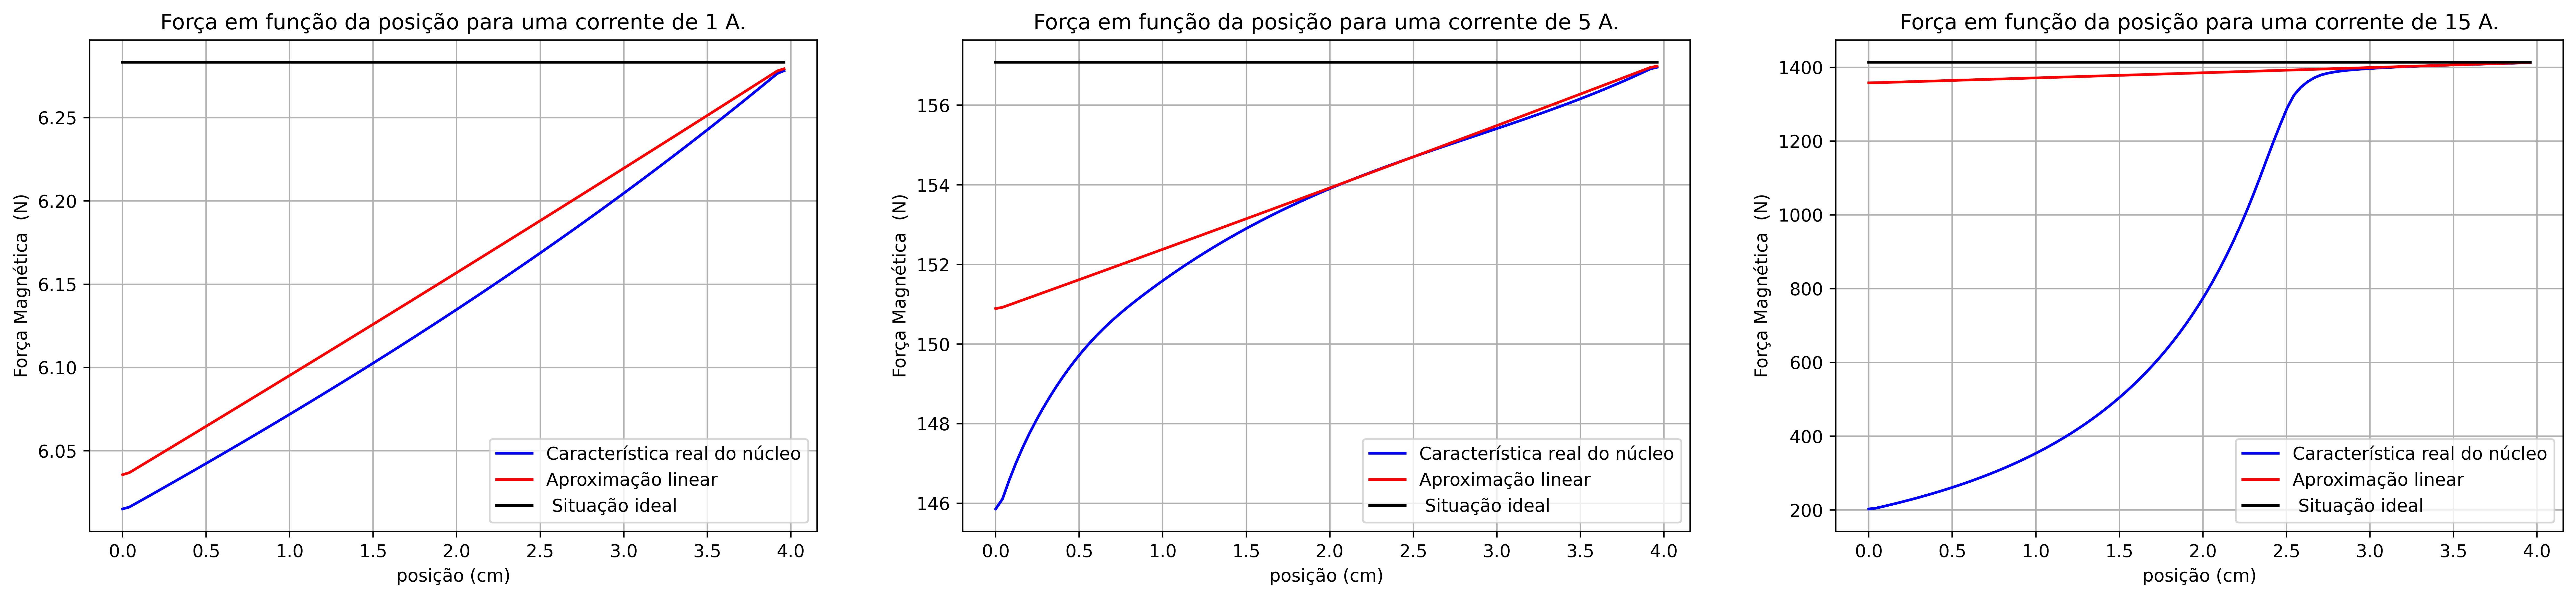

In [ ]:
'''Item 3: Casos de testes de 1A, 5A e 15A'''
i_bobina =[1,5,15]
k = 0

#Configurando o plot
plt.figure(figsize=(25,5),dpi=500)
for i in i_bobina:
  Forca_ideal,Forca_linear,Forca_real,x,iMax = calc_forc(i,B,H)
  plt.subplot(1,len(i_bobina),k+1)
  plt.plot(x[0:Numero_de_pontos-1]*100,abs(Forca_real),'b')
  plt.plot(x[0:Numero_de_pontos-1]*100,abs(Forca_linear),'r')
  plt.plot(x[0:Numero_de_pontos-1]*100,abs(Forca_ideal),'k')
  plt.legend(['Característica real do núcleo','Aproximação linear', ' Situação ideal'])
  plt.title(f'Força em função da posição para uma corrente de {i} A.')
  plt.xlabel('posição (cm)')
  plt.ylabel('Força Magnética  (N)')
  plt.grid(True)
  k+=1

In [ ]:
print(f'Corrente onde é possível ser calculado a força sem comportamentos anómalos Imax = {iMax:.4f}A')

Corrente onde é possível ser calculado a força sem comportamentos anómalos Imax = 23.2805A


<ipython-input-69-0f1987600bea>:81: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  Forca_real   = derivative(f_real,x[0:Numero_de_pontos-1],dx=d/(Numero_de_pontos-1))
<ipython-input-69-0f1987600bea>:82: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  Forca_linear = derivative(f_linear,x[0:Numero_de_pontos-1],dx=d/(Numero_de_pontos-1))
<ipython-input-69-0f1987600bea>:83: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod

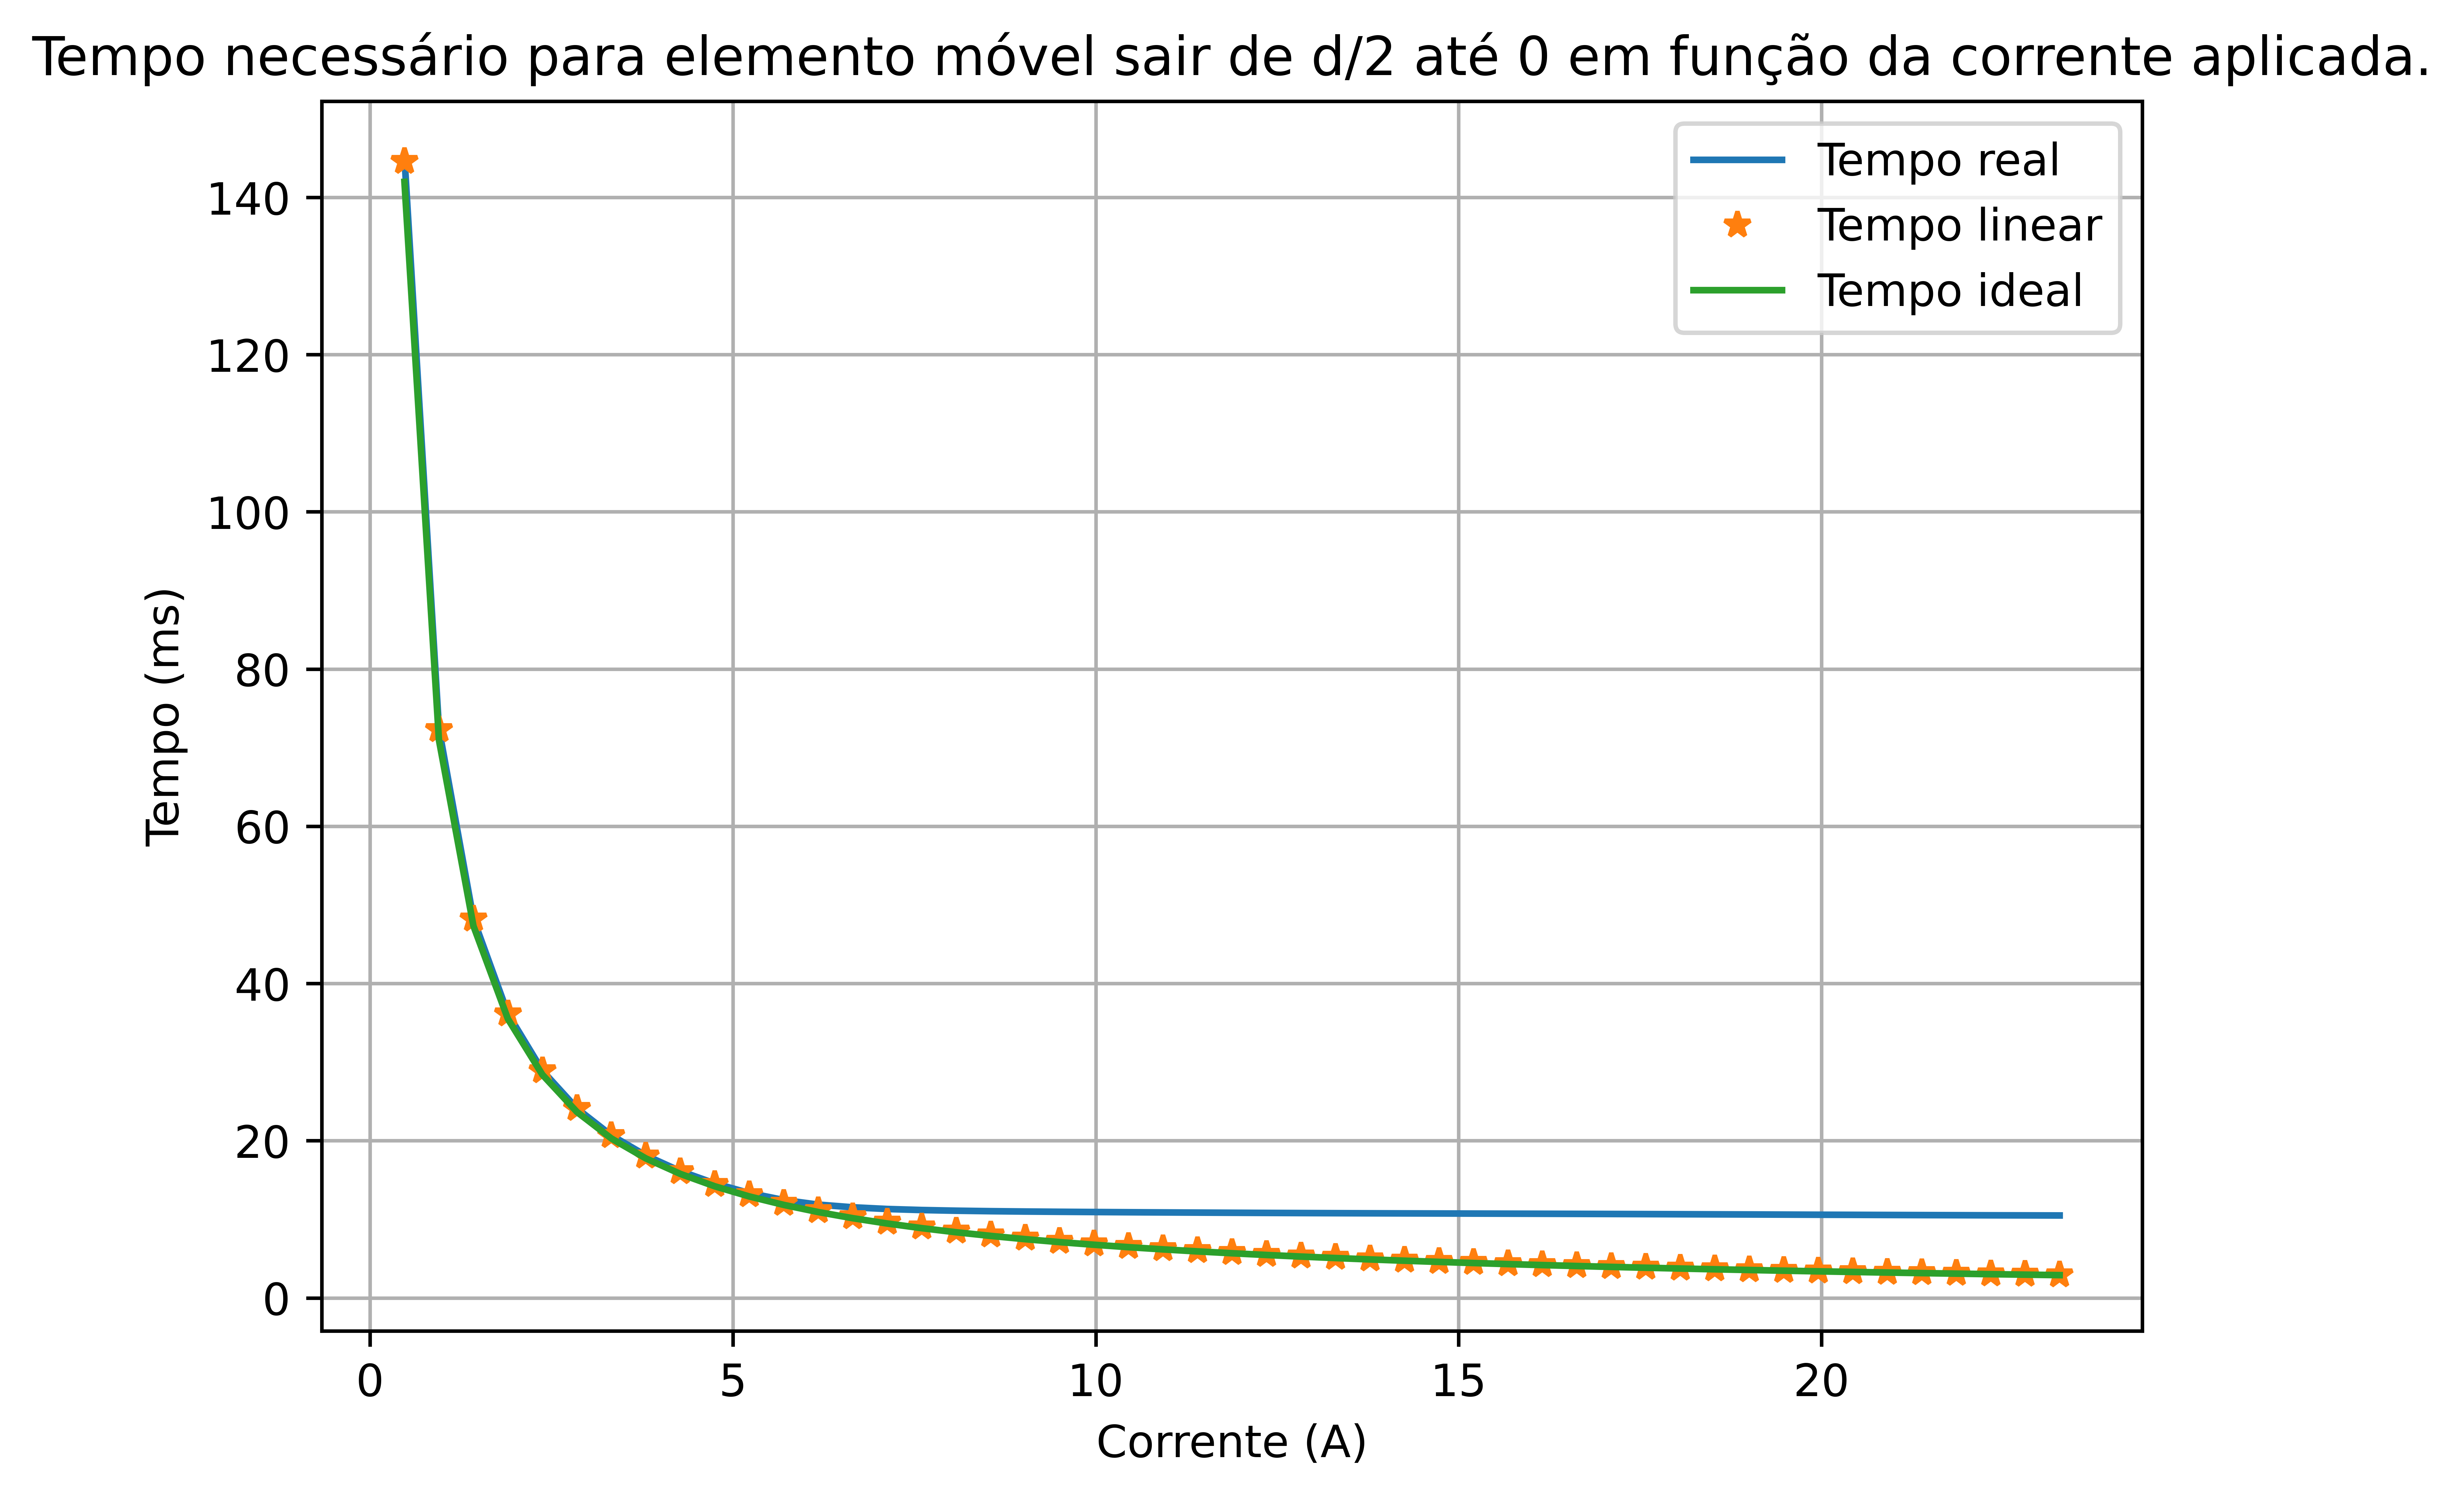

In [ ]:
'''Item 4:Gráfico do tempo necessário para o elemento móvel sair da posição x=d/2 até a
posição x=0 em função da corrente aplicada na bobina.'''

#Variação da corrente intervalo de 0 até corrente Maxima de confiabilidade do calcule da força
i_corrente = np.linspace(0,iMax)
tempo_real = np.zeros(len(i_corrente))
tempo_linear = np.zeros(len(i_corrente))
tempo_ideal = np.zeros(len(i_corrente))

#Calculo do tempo em fução da corrente aplicada
for i in range(len(i_corrente)):
  Forca_ideal,Forca_linear,Forca_real,x,iMax = calc_forc(i_corrente[i],B,H)
  x_linha = (x[0:len(x)//2:])[::-1] #Sair de 2 até 0
  Velocidade_Real = np.sqrt((2/massa)*integral_indefinida(Forca_real,x_linha))[2:Numero_de_pontos//2]
  Velocidade_Linear = np.sqrt((2/massa)*integral_indefinida(Forca_linear,x_linha))[2:Numero_de_pontos//2]
  Velocidade_Ideal = np.sqrt((2/massa)*integral_indefinida(Forca_ideal,x_linha))[2:Numero_de_pontos//2]
  tempo_real[i] = sci.integrate.trapezoid(1/Velocidade_Real,(x_linha[2:])[::-1])
  tempo_linear[i] = sci.integrate.trapezoid(1/Velocidade_Linear,(x_linha[2:])[::-1])
  tempo_ideal[i] = sci.integrate.trapezoid(1/Velocidade_Ideal,(x_linha[2:])[::-1])

plt.figure(figsize=(25,5),dpi=1000)
plt.subplot(1, 3, 1)
plt.plot(i_corrente,tempo_real*1000)
plt.plot(i_corrente,tempo_linear*1000,"*")
plt.plot(i_corrente,tempo_ideal*1000)
plt.legend(["Tempo real", "Tempo linear", "Tempo ideal"])
plt.title("Tempo necessário para elemento móvel sair de d/2 até 0 em função da corrente aplicada.")
plt.xlabel("Corrente (A)")
plt.ylabel("Tempo (ms)")
plt.grid(True)